# **AITANA**

In [1]:
# E-Waste Image Classification Complete Notebook

# STEP 1: Mount Google Drive and Set Dataset Path

from google.colab import drive
drive.mount('/content/drive')

import os

DATASET_PATH = "/content/drive/MyDrive/ewaste"
CATEGORIES = sorted(os.listdir(DATASET_PATH))
print("Detected classes:", CATEGORIES)



Mounted at /content/drive
Detected classes: ['camera', 'keyboard', 'laptop', 'microwave', 'mobile', 'mouse', 'smartwatch', 'tv']


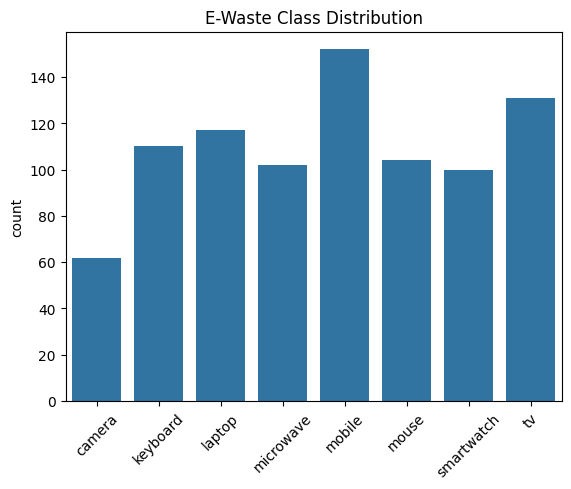

In [2]:
# STEP 2: Visualize Class Distribution

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

all_classes = []
for category in CATEGORIES:
    category_path = os.path.join(DATASET_PATH, category)
    all_classes += [category] * len(os.listdir(category_path))

sns.countplot(x=all_classes)
plt.title("E-Waste Class Distribution")
plt.xticks(rotation=45)
plt.show()


In [3]:
# STEP 3: Load Data with Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 704 images belonging to 8 classes.
Found 173 images belonging to 8 classes.


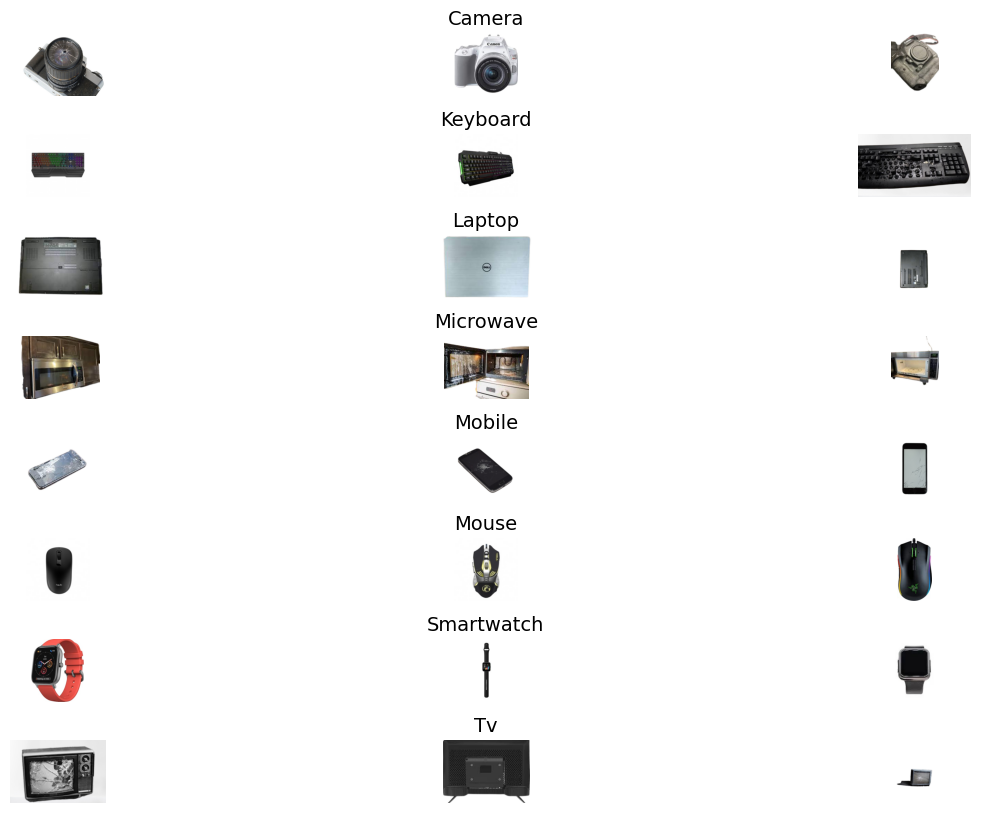

In [5]:
# STEP 4: VISUALIZATION 2: Sample Images Grid (3 images per class)

import random
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec
import cv2

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(len(CATEGORIES), 3, wspace=0.4, hspace=0.6)

for i, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_PATH, category)
    sample_images = random.sample(os.listdir(folder_path), min(3, len(os.listdir(folder_path))))

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(gs[i, j])
        ax.imshow(img)
        ax.axis('off')
        if j == 1:
            ax.set_title(category.capitalize(), fontsize=14)

plt.show()

In [6]:
# STEP 5: Build Model with Transfer Learning

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(CATEGORIES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# STEP 6: Train the Model

EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.1713 - loss: 2.3787 - val_accuracy: 0.2023 - val_loss: 2.0457
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 770ms/step - accuracy: 0.2302 - loss: 2.0465 - val_accuracy: 0.3526 - val_loss: 1.7844
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 743ms/step - accuracy: 0.3166 - loss: 1.7704 - val_accuracy: 0.4220 - val_loss: 1.5966
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 641ms/step - accuracy: 0.4301 - loss: 1.6014 - val_accuracy: 0.5723 - val_loss: 1.4678
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 646ms/step - accuracy: 0.4713 - loss: 1.4995 - val_accuracy: 0.5549 - val_loss: 1.3532
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 664ms/step - accuracy: 0.5439 - loss: 1.2970 - val_accuracy: 0.6821 - val_loss: 1.1974
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 646ms/step - accuracy: 0.6304 - loss: 1.1624 - val_accuracy: 0.6763 - val_loss: 1.1193
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 641ms/step - accuracy: 0.6018 - loss: 1.1402 - val_accurac

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step
Classification Report:
              precision    recall  f1-score   support

      camera       0.00      0.00      0.00        12
    keyboard       0.08      0.09      0.09        22
      laptop       0.08      0.09      0.08        23
   microwave       0.15      0.15      0.15        20
      mobile       0.24      0.27      0.25        30
       mouse       0.24      0.20      0.22        20
  smartwatch       0.14      0.20      0.17        20
          tv       0.05      0.04      0.04        26

    accuracy                           0.14       173
   macro avg       0.12      0.13      0.12       173
weighted avg       0.13      0.14      0.13       173



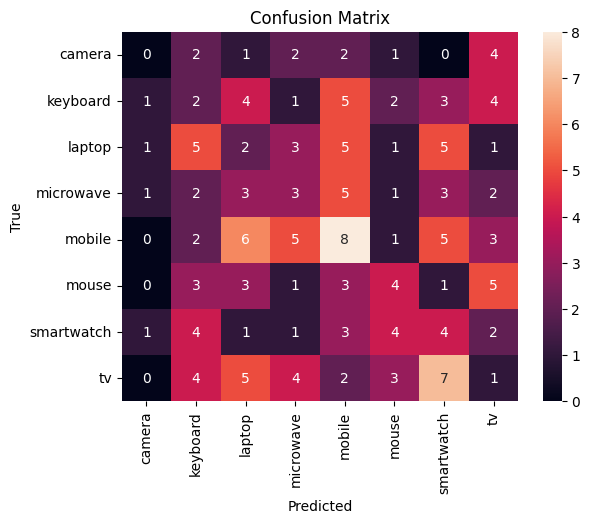

In [9]:
# STEP 7: Evaluate the Model

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation set
val_steps = val_generator.samples // val_generator.batch_size
Y_pred = model.predict(val_generator, steps=val_steps + 1)
y_pred = np.argmax(Y_pred, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [12]:
# STEP 8: Save the Model

model.save('ewaste_model.h5')


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step
Classification Report on Validation Data:
              precision    recall  f1-score   support

      camera       0.25      0.08      0.12        12
    keyboard       0.09      0.09      0.09        22
      laptop       0.15      0.17      0.16        23
   microwave       0.12      0.10      0.11        20
      mobile       0.14      0.17      0.15        30
       mouse       0.17      0.15      0.16        20
  smartwatch       0.19      0.25      0.22        20
          tv       0.15      0.15      0.15        26

    accuracy                           0.15       173
   macro avg       0.16      0.15      0.15       173
weighted avg       0.15      0.15      0.15       173



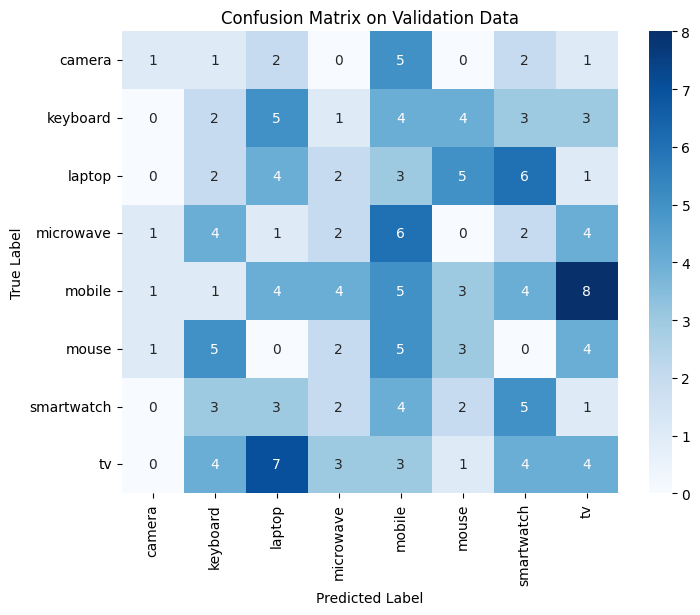

In [14]:
# STEP 9: Calculate Precision, Recall, F1-Score on Validation Data

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reset validation generator for fresh predictions
val_generator.reset()
val_steps = val_generator.samples // val_generator.batch_size + 1

# Predict probabilities and convert to class indices
val_preds_prob = model.predict(val_generator, steps=val_steps)
val_preds = np.argmax(val_preds_prob, axis=1)

# True labels
val_true = val_generator.classes

# Print classification report
print("Classification Report on Validation Data:")
print(classification_report(val_true, val_preds, target_names=val_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(val_true, val_preds)
cm_labels = list(val_generator.class_indices.keys())

# Plot confusion matrix heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=cm_labels, yticklabels=cm_labels, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Data')
plt.show()

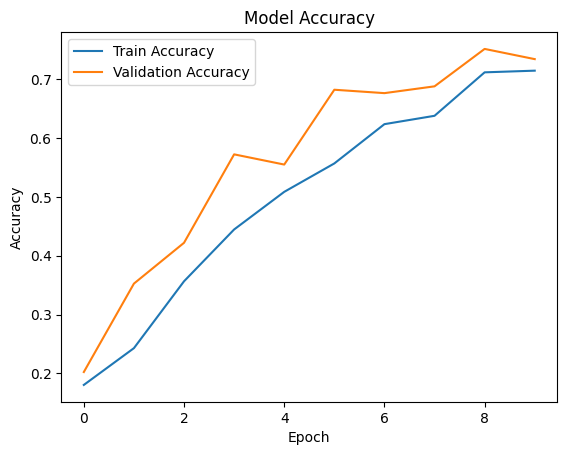

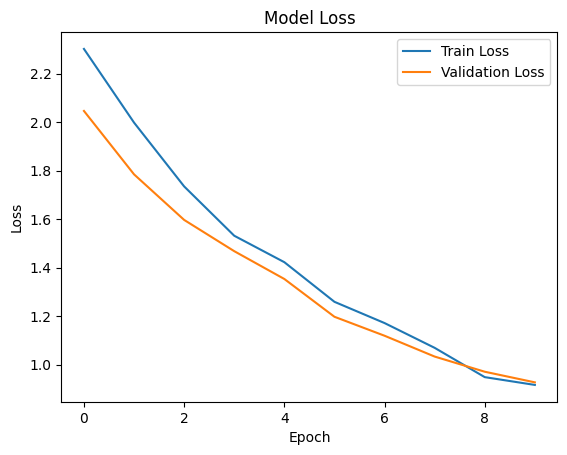

In [15]:
# STEP 10: Plot Training History

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Saving 61f-40lwnQL._AC_UL400_.jpg to 61f-40lwnQL._AC_UL400_.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


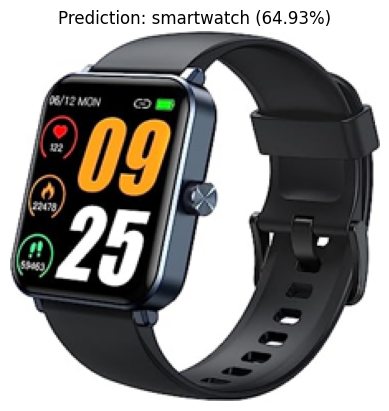

✅ Classified as: smartwatch with 64.93% confidence

💡 Fun Fact about Smartwatch:
⌚ Smartwatches can be used as sensors in DIY fitness or health monitoring projects.

♻️ Reuse Ideas:
- 📶 IoT Sensor: Use built-in sensors for basic IoT experiments.
- 📅 Task Tracker: Convert it into a task reminder for kids or elders.




In [26]:
# # STEP 11: Testing the Trained Model

from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Class labels
class_names = ['camera', 'keyboard', 'laptop', 'microwave', 'mobile', 'mouse', 'smartwatch', 'tv']

# Fun facts and reuse ideas dictionary
info = {
    'laptop': {
        'fun_fact': "💡 Laptops have reusable RAM, SSDs, and displays that can be upcycled into other gadgets.",
        'reuse_ideas': [
            "🖼️ Digital Picture Frame: Turn the screen into a photo display.",
            "💻 Student Lab: Install Linux and donate it for tech education."
        ]
    },
    'camera': {
        'fun_fact': "📸 Old digital cameras often use CCD sensors that are now considered rare and valuable for optics experiments.",
        'reuse_ideas': [
            "🎥 Time-lapse Recorder: Repurpose as a time-lapse camera.",
            "🔍 Science Kit: Use the lens for homemade microscopes."
        ]
    },
    'microwave': {
        'fun_fact': "💡 Microwaves contain powerful magnets and motors which can be repurposed.",
        'reuse_ideas': [
            "🧲 Salvage Magnets: Reuse in science demos or motors.",
            "⚙️ Motor Uses: Use the spinning plate motor for small DIY robots."
        ]
    },
    'keyboard': {
        'fun_fact': "⌨️ Most keyboards are durable and can last over 50 million keystrokes!",
        'reuse_ideas': [
            "🕒 Word Clock: Turn keys into a clock face.",
            "🔤 Alphabet Toy: Teach kids letters using painted keys."
        ]
    },
    'mobile': {
        'fun_fact': "📱 Mobiles contain more gold per gram than gold ore—about 100 times more!",
        'reuse_ideas': [
            "📚 Learning Device: Preload eBooks and apps for education.",
            "🎮 Game Console: Use old phones as handheld gaming devices."
        ]
    },
    'mouse': {
        'fun_fact': "🖱️ Optical mice use tiny cameras to detect surface movement—cool tech in a tiny shell!",
        'reuse_ideas': [
            "🎮 Game Button: Convert mouse buttons into arcade game controls.",
            "🔍 Mini Microscope: Repurpose the sensor for basic microscopy."
        ]
    },
    'tv': {
        'fun_fact': "📺 TVs are treasure troves of capacitors, screens, and circuit boards for reuse.",
        'reuse_ideas': [
            "🖼️ Smart Mirror: Turn the screen into a digital mirror.",
            "📊 Wall Display: Use it for dashboards or learning boards."
        ]
    },
    'smartwatch': {
        'fun_fact': "⌚ Smartwatches can be used as sensors in DIY fitness or health monitoring projects.",
        'reuse_ideas': [
            "📶 IoT Sensor: Use built-in sensors for basic IoT experiments.",
            "📅 Task Tracker: Convert it into a task reminder for kids or elders."
        ]
    }
}

# Upload image(s)
uploaded = files.upload()

# Predict and display function
def preprocess_and_predict(img_path):
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    pred_index = np.argmax(prediction)
    confidence = prediction[0][pred_index]

    # Display result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {class_names[pred_index]} ({confidence*100:.2f}%)")
    plt.show()

    predicted_label = class_names[pred_index]
    return predicted_label, confidence

# Loop through uploaded files and classify
for filename in uploaded.keys():
    label, conf = preprocess_and_predict(filename)
    print(f"✅ Classified as: {label} with {conf*100:.2f}% confidence")

    if label in info:
        print(f"\n💡 Fun Fact about {label.capitalize()}:")
        print(info[label]['fun_fact'])

        print("\n♻️ Reuse Ideas:")
        for idea in info[label]['reuse_ideas']:
            print(f"- {idea}")
        print("\n" + "="*50 + "\n")
